In [9]:
import h5py

types = [
    "stimulation_only",
    "stimulation_saline",
    "stimulation_low_cckglp1",
    "stimulation_high_cckglp1",
]

data_stim = None
with h5py.File('../../data/i2Move/vn_data.h5', 'r') as f:
    data_stim = f['stimulation_only']
    data = data_stim['time_series_data'][:]
    labels = data_stim['labels'][:]
    info = data_stim['info'][:].astype(str)  # Convert byte strings back to normal strings


In [10]:
# data = data_stim['time_series_data']
# labels = data_stim['labels']
# info = data_stim['info'][:].astype(str)  # Convert byte strings back to normal strings

print('Data shape:', data.shape)
print('Labels shape:', labels.shape)
print('Info shape:', info.shape)

Data shape: (976, 4001)
Labels shape: (976, 2)
Info shape: (976,)


Time series data plots

In [11]:
import random
from collections import Counter

label_counts_pw = Counter(list(labels[:, 0]))
print('Pulse widths label counts:', label_counts_pw)

label_counts_current = Counter(list(labels[:, 1]))
print('Current label counts:', label_counts_current)

# Get unique values for each column
unique_pw = set(labels[:, 0])
unique_current = set(labels[:, 1])

# Get all the unique combinations of pulse width and current
unique_combinations = set([(pw, current) for pw in unique_pw for current in unique_current])

# Filter out the combinations that don't exist in the data
existing_combinations = set([(pw, current) for pw, current in unique_combinations if (pw, current) in labels])

# Sample 10 random combinations
random_label_combinations = random.sample(sorted(existing_combinations), 6)

Pulse widths label counts: Counter({0.1: 224, 0.2: 224, 0.5: 224, 1.0: 224, 5.0: 80})
Current label counts: Counter({0.2: 61, 0.5: 61, 0.8: 61, 1.0: 61, 1.1: 61, 1.2: 61, 1.4: 61, 1.6: 61, 1.8: 61, 2.0: 61, 0.1: 33, 0.30000000000000004: 33, 0.4: 33, 0.6: 33, 0.7000000000000001: 33, 0.9000000000000001: 33, 1.3: 28, 1.5: 28, 1.7: 28, 2.4: 28, 2.8: 28, 3.0: 28})


In [5]:
random_label_combinations

[(0.2, 1.4), (5.0, 1.1), (0.1, 0.8), (0.1, 2.0), (0.5, 0.6), (0.1, 3.0)]

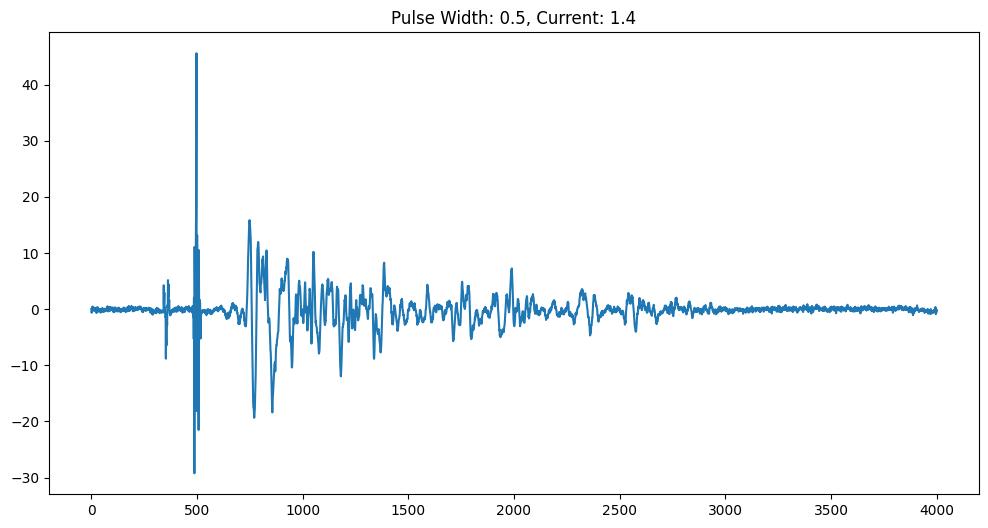

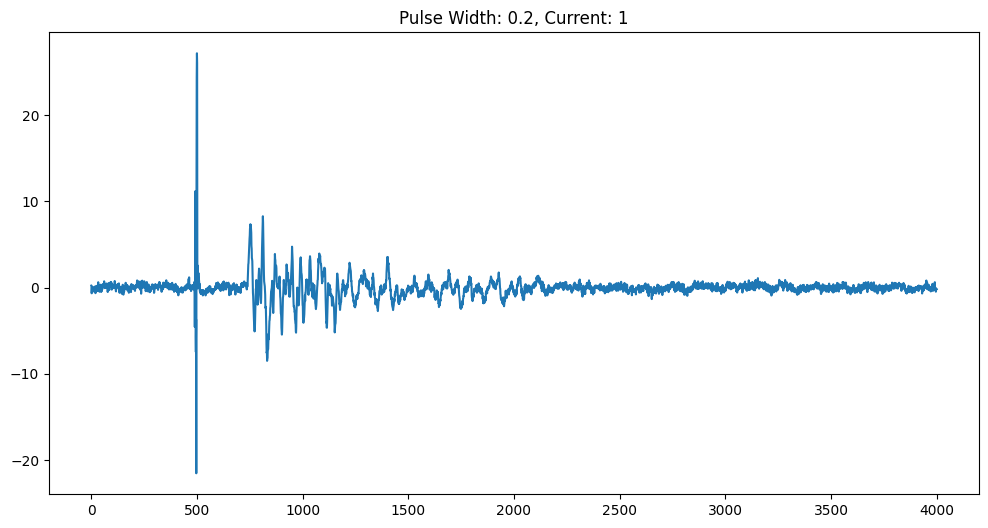

In [23]:
# Do a subplot for all the data which matches the random 6 combinations
from matplotlib import pyplot as plt
import numpy as np

plot_labels = [(0.5, 1.4), (0.2, 1)]

for i, (pw, current) in enumerate(plot_labels):
    indices = np.where((labels[:, 0] == pw) & (labels[:, 1] == current))[0]
    plt.figure(figsize=(12, 6))
    avg = np.mean(data[indices], axis=0)
    plt.plot(avg)
    plt.title(f'Pulse Width: {pw}, Current: {current}')
    plt.show()

In [16]:
np.where((labels[:, 0] == 0.5) & (labels[:, 1] == 1))

(array([ 41, 105, 169, 249, 313, 377, 441, 505, 569, 633, 697, 777, 857,
        937], dtype=int64),)

## Fourier Analysis

In [21]:
fs = 20000
Ts = 1/fs

def apply_fft(time_series):
    fft_result = np.fft.fft(time_series)
    fft_freq = np.fft.fftfreq(len(time_series), d=Ts)
    return fft_result, fft_freq

# Compute Fourier Transform and identify most prominent frequency
prominent_frequencies = []

total_power = []

for time_series in data:
    fft_result, fft_freq = apply_fft(time_series)
    # Find the frequency with the highest magnitude
    idx = np.argmax(np.abs(fft_result[:len(fft_result)//2]))  # Consider only positive frequencies
    prominent_frequencies.append(fft_freq[idx])

    # Compute total power
    total_power.append(np.sum(np.abs(fft_result)**2))

prominent_frequencies = np.array(prominent_frequencies)
total_power = np.array(total_power)


In [29]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Times New Roman'

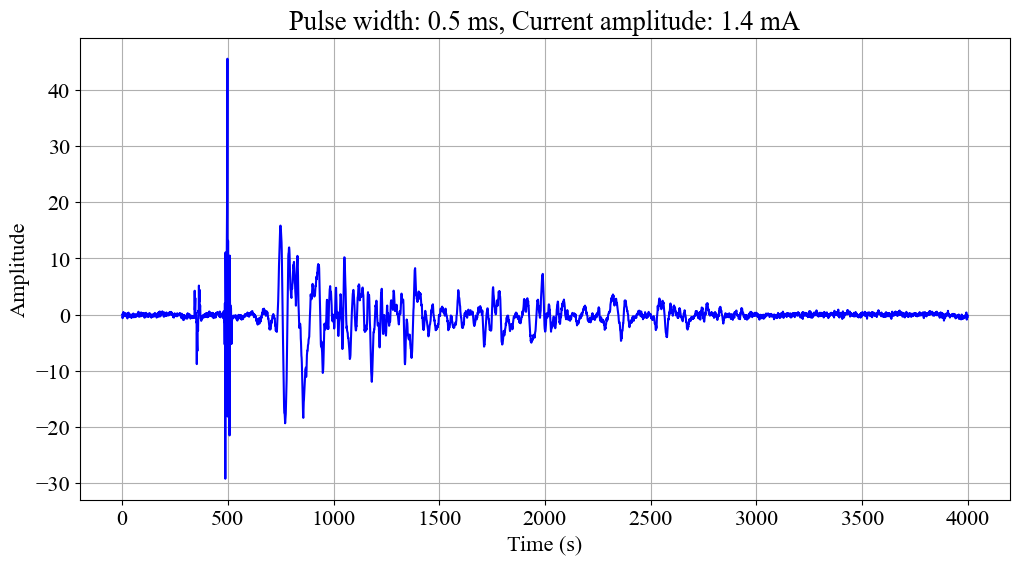

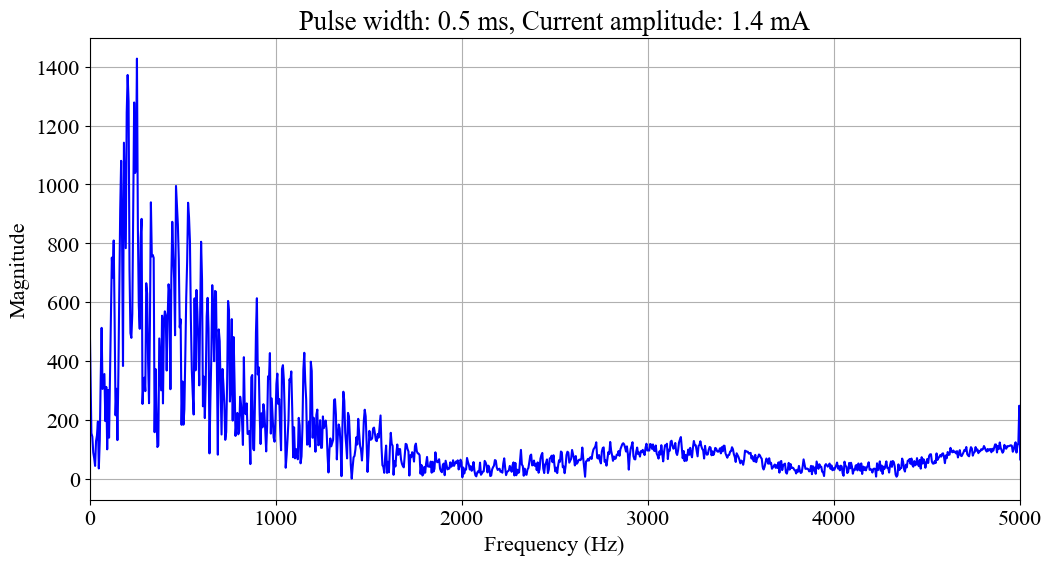

In [32]:
fs = 20000
Ts = 1/fs

def apply_fft(time_series):
    fft_result = np.fft.fft(time_series)
    fft_freq = np.fft.fftfreq(len(time_series), d=Ts)
    return fft_result[:len(fft_result)//2], fft_freq[:len(fft_result)//2]

plot_labels = [(0.5, 1.4)]

for i, (pw, current) in enumerate(plot_labels):
    indices = np.where((labels[:, 0] == pw) & (labels[:, 1] == current))[0]
    plt.figure(figsize=(12, 6))
    avg = np.mean(data[indices], axis=0)
    plt.plot(avg, c='b')
    plt.title(f'Pulse width: {pw} ms, Current amplitude: {current} mA')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.savefig(f'./i2move_cnap_{pw}_{current}.png', dpi=300)
    plt.savefig(f'./i2move_cnap_{pw}_{current}.eps', dpi=300, format='eps')
    plt.show()

    fft_result, fft_freq = apply_fft(avg)
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freq, np.abs(fft_result), c='b')
    plt.title(f'Pulse width: {pw} ms, Current amplitude: {current} mA')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim([0, 5000])
    plt.grid(True)
    plt.savefig(f'./i2move_fft_{pw}_{current}.png', dpi=300)
    plt.savefig(f'./i2move_fft_{pw}_{current}.eps', dpi=300, format='eps')
    plt.show()
    

            Label  Prominent_Frequency
count  976.000000           976.000000
mean     0.822951           996.467072
std      1.293061          1740.138154
min      0.100000             0.000000
25%      0.200000           149.962509
50%      0.500000           259.935016
75%      1.000000           349.912522
max      5.000000          5003.749063


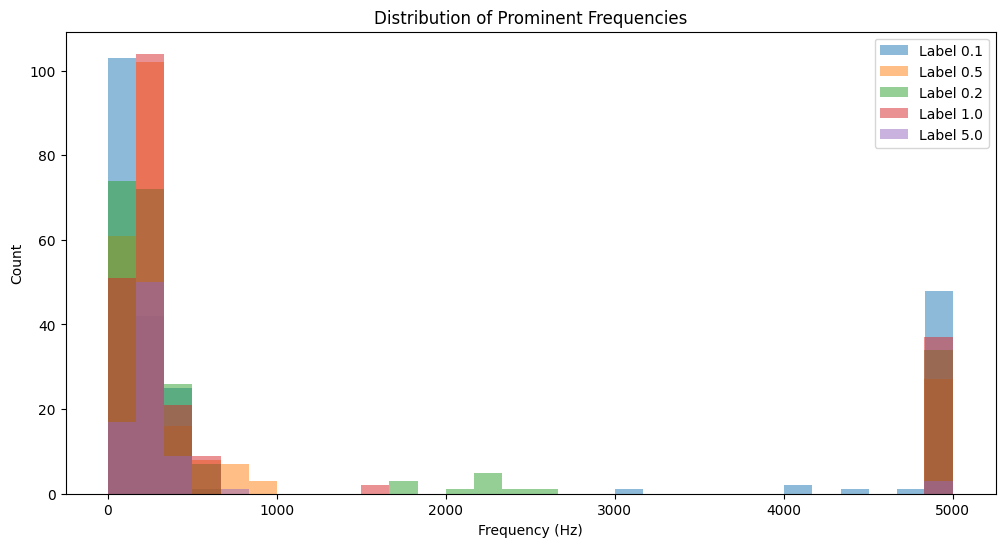

In [22]:
import pandas as pd

# Create a DataFrame for statistical analysis
# strlabels = np.array([f'{pw}, {current}' for pw, current in labels])
lbl = labels[:, 0]
data_df = pd.DataFrame({
    'Label': lbl,
    'Prominent_Frequency': prominent_frequencies
})

# Describe the prominent frequencies
print(data_df.describe())

# Analyze the distribution of prominent frequencies
plt.figure(figsize=(12, 6))
for label in set(lbl):
    subset = data_df[data_df['Label'] == label]
    plt.hist(subset['Prominent_Frequency'], bins=30, alpha=0.5, label=f'Label {label}')
# plt.hist(data_df['Prominent_Frequency'], bins=30, alpha=0.5)
plt.title('Distribution of Prominent Frequencies')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.legend()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.hist(data_df['Prominent_Frequency'], bins=30, alpha=0.5)
# plt.title('Distribution of Prominent Frequencies')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Count')
# plt.legend()
# plt.show()

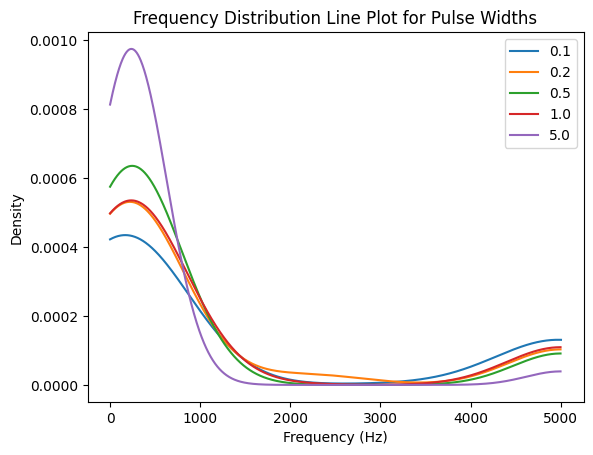

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Plotting
lbls = data_df['Label'].unique()

for lbl in lbls:
    subset = data_df[data_df['Label'] == lbl]['Prominent_Frequency']
    
    # Kernel Density Estimation
    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 1000)
    kde_vals = kde(x_vals)
    
    # Plot the KDE line
    plt.plot(x_vals, kde_vals, label=f'{lbl}')

# Add titles and labels
plt.title('Frequency Distribution Line Plot for Pulse Widths')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()


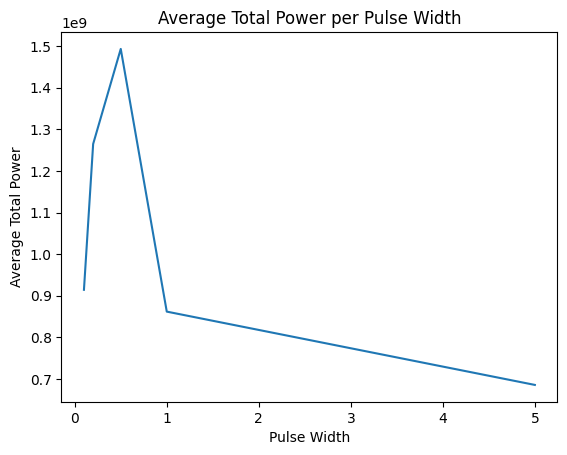

In [24]:
# Plot average total power per label

data_df['Total_Power'] = total_power

# Plotting
pulse_widths = data_df['Label'].unique()
pulse_width_power = np.zeros(len(pulse_widths))

for i in range(len(pulse_widths)):
    subset = data_df[data_df['Label'] == pulse_widths[i]]['Total_Power']
    avg_power = np.mean(subset)
    pulse_width_power[i] = avg_power

plt.plot(pulse_widths, pulse_width_power)
plt.title('Average Total Power per Pulse Width')
plt.xlabel('Pulse Width')
plt.ylabel('Average Total Power')
plt.show()


## PCA Analysis

C:\Users\btari\AppData\Local\Temp\ipykernel_16128\3999889160.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_data[i, 0], reduced_data[i, 1], c=color)


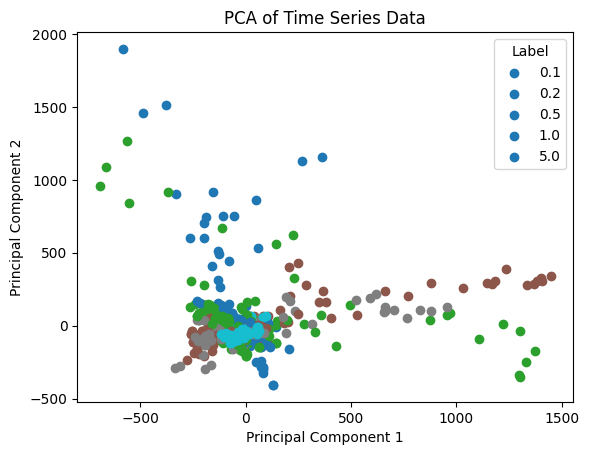

In [25]:
# Do PCA on the data
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Assuming the first column of labels contains the relevant values
labels_to_use = labels[:, 0]  # Extract the first column (modify if needed)
unique_labels = np.unique(labels_to_use)
num_labels = len(unique_labels)

# Create a discrete colormap
cmap = plt.get_cmap('tab10')  # Choose a colormap with 10 colors
colors = cmap(np.linspace(0, 1, num_labels))  # Discretize the colormap
label_colors = {label: color for label, color in zip(unique_labels, colors)}

# Plot the reduced data with color-coding
for i in range(len(labels_to_use)):
    label = labels_to_use[i]
    color = label_colors.get(label)  # Use get() to handle potential missing labels
    plt.scatter(reduced_data[i, 0], reduced_data[i, 1], c=color)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Time Series Data')

if num_labels <= 10:  # Only add legend if there are few labels
    legend_labels = [str(label) for label in unique_labels]
    plt.legend(legend_labels, title="Label")

plt.show()




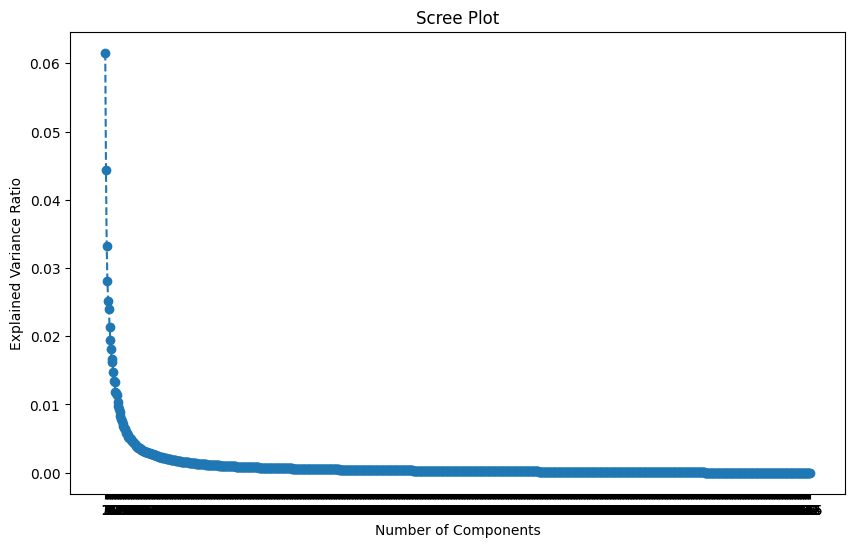

Number of components to explain 95% variance: 493


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

labels_pw = labels[:, 0]
labels_c = labels[:, 1]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data)

# Apply PCA without specifying the number of components

pca = PCA()
pca.fit(features_scaled)

# Create Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# Determine the number of components to use
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f'Number of components to explain 95% variance: {n_components}')


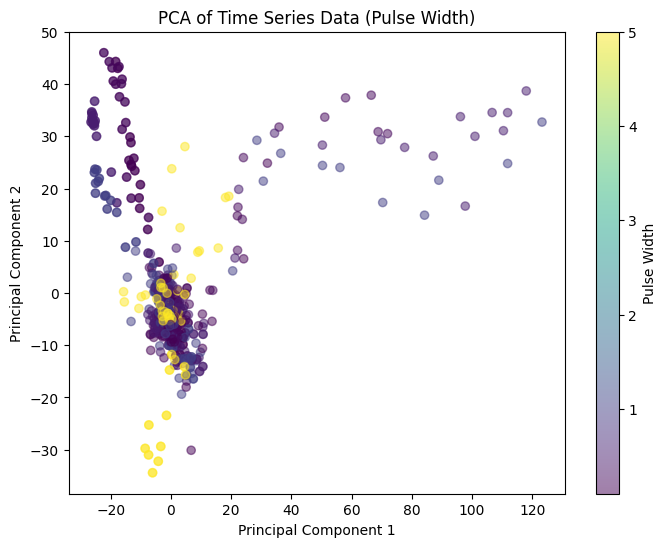

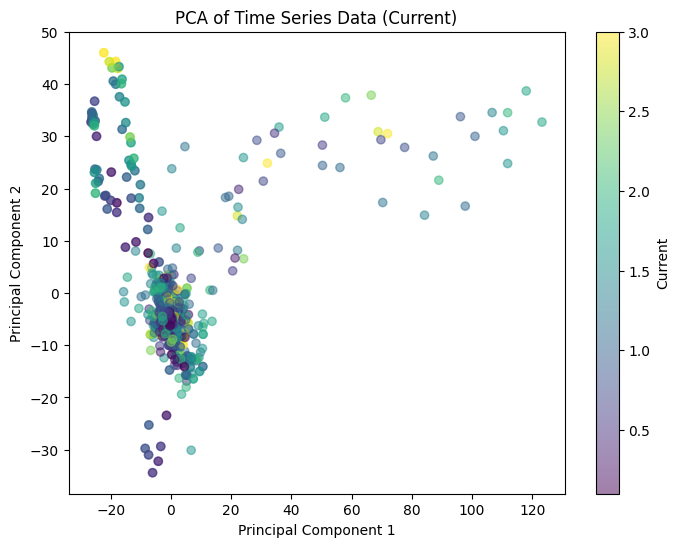

In [27]:

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['label1'] = labels_pw
pca_df['label2'] = labels_c

# Visualize the PCA results (using the first two components for simplicity)

unique_labels_pw = np.unique(labels_to_use)
num_labels_pw = len(unique_labels_pw)

# Create a discrete colormap
cmap = plt.get_cmap('tab10')  # Choose a colormap with 10 colors
colors = cmap(np.linspace(0, 1, num_labels_pw))  # Discretize the colormap
label_colors = {label: color for label, color in zip(unique_labels, colors)}

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=labels_pw, cmap='viridis', alpha=0.5)
plt.title('PCA of Time Series Data (Pulse Width)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Pulse Width')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=labels_c, cmap='viridis', alpha=0.5)
plt.title('PCA of Time Series Data (Current)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Current')
plt.show()


c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


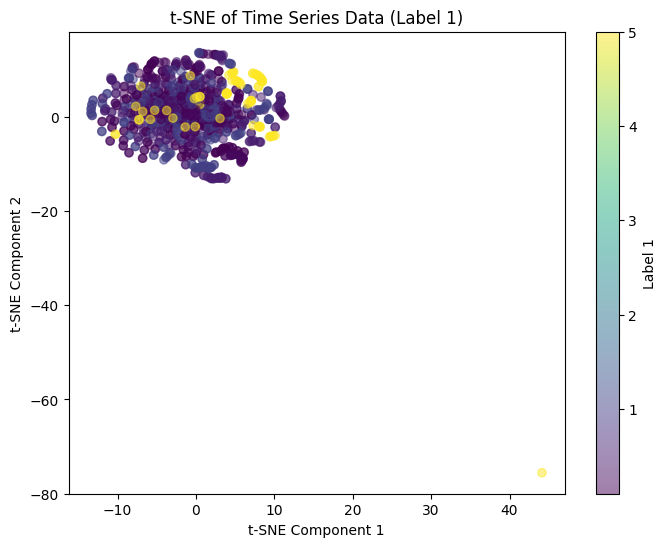

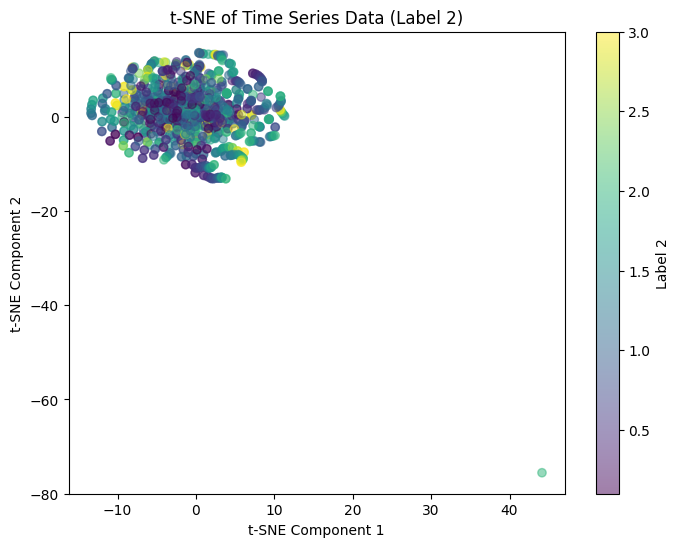

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the scaled features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(features_scaled)

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label1'] = labels_pw
tsne_df['label2'] = labels_c

# Visualize the t-SNE results for Label 1
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['label1'], cmap='viridis', alpha=0.5)
plt.title('t-SNE of Time Series Data (Label 1)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Label 1')
plt.show()

# Visualize the t-SNE results for Label 2
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['label2'], cmap='viridis', alpha=0.5)
plt.title('t-SNE of Time Series Data (Label 2)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Label 2')
plt.show()


In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from scipy.signal import decimate

# X = decimate(data[:, :-1], 5, axis=1)
X = data[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, labels[:, 0], test_size=0.2, random_state=42)

# Normalize the data if necessary
scaler_X = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_reshaped = scaler_X.fit_transform(X_train_reshaped)
X_test_reshaped = scaler_X.transform(X_test_reshaped)

X_train = X_train_reshaped.reshape(X_train.shape)
X_test = X_test_reshaped.reshape(X_test.shape)

scaler_y = StandardScaler()
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)
y_train_reshaped = scaler_y.fit_transform(y_train_reshaped)
y_test_reshaped = scaler_y.transform(y_test_reshaped)
y_train = y_train_reshaped.reshape(y_train.shape)
y_test = y_test_reshaped.reshape(y_test.shape)


In [42]:
X_train.shape

(780, 4000)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization

# Define the model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
model.add(LSTM(64))
# model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
# model.add(Dense(2))  # Two output neurons for pulse width and current
model.add(Dense(1))  # Two output neurons for pulse width and current

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train[:, 0], epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test[:, 0])
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)
# Inverse transform the predictions to get original scale
predictions = scaler_y.inverse_transform(predictions)

## CNNs

CNN with 1 regression output

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))  # Two output neurons for pulse width and current

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)


c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 2.3669 - mae: 1.1972 - val_loss: 1.2174 - val_mae: 0.9011
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 750ms/step - loss: 1.3681 - mae: 0.8828 - val_loss: 1.2707 - val_mae: 0.9710
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 731ms/step - loss: 1.0070 - mae: 0.7499 - val_loss: 1.3401 - val_mae: 0.9907
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 733ms/step - loss: 0.8717 - mae: 0.6938 - val_loss: 1.6886 - val_mae: 1.2076
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 733ms/step - loss: 0.8278 - mae: 0.6647 - val_loss: 2.3016 - val_mae: 1.4864
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 744ms/step - loss: 0.7343 - mae: 0.6271 - val_loss: 2.0227 - val_mae: 1.3786
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 734ms/step - loss: 0.6998 - mae: 0.6066 - val_loss: 1.7174 - val_mae: 1.2124
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 738ms/step - loss: 0.6051 - mae: 0.5609 - val_loss: 2.1288 - val_mae: 1.3990
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 731ms/ste

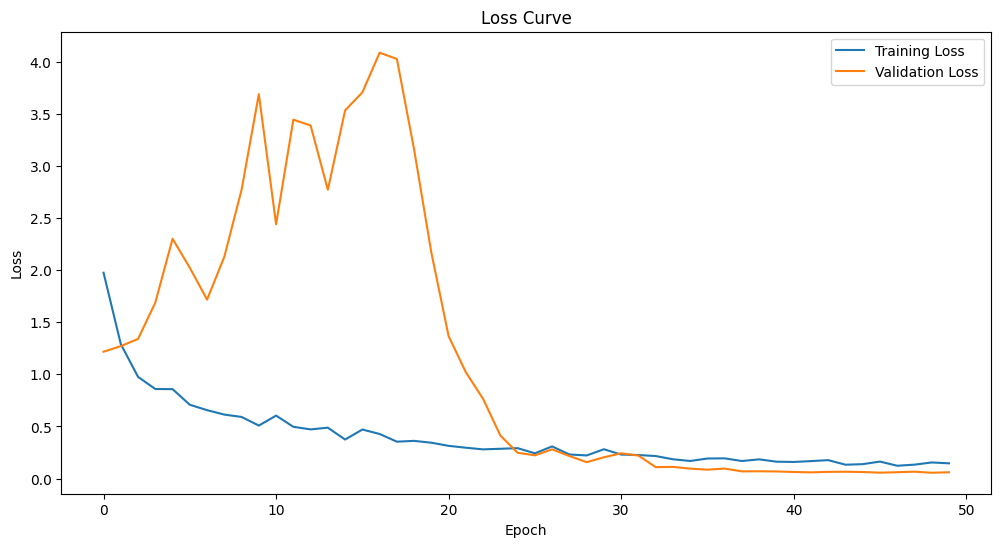

In [48]:
# plot the loss curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


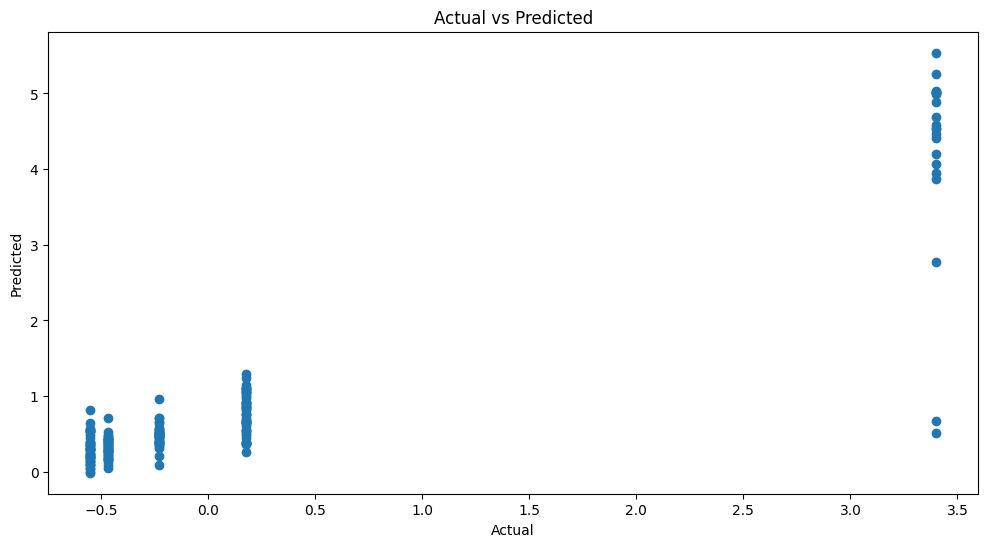

In [49]:
# scatter plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

CNN with classification of pulse width using only time series

In [53]:
import pandas as pd
import numpy as np
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from scipy.signal import decimate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# X = decimate(data[:, :-1], 5, axis=1)
X = data[:, :-1]

# One-hot encode labels for multi-class classification
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels[:, 0].ravel())
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data if necessary
scaler_X = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_reshaped = scaler_X.fit_transform(X_train_reshaped)
X_test_reshaped = scaler_X.transform(X_test_reshaped)

X_train = X_train_reshaped.reshape(X_train.shape)
X_test = X_test_reshaped.reshape(X_test.shape)

# Define the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Change the output layer to match the number of classes and use softmax activation
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model with categorical_crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train and X_test to have the right shape for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# print(predicted_labels)


c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 763ms/step - accuracy: 0.2828 - loss: 1.9793 - val_accuracy: 0.3013 - val_loss: 1.5978
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 678ms/step - accuracy: 0.5090 - loss: 1.2754 - val_accuracy: 0.1987 - val_loss: 2.0716
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 706ms/step - accuracy: 0.5885 - loss: 1.0489 - val_accuracy: 0.1859 - val_loss: 2.5913
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 706ms/step - accuracy: 0.6714 - loss: 0.8450 - val_accuracy: 0.1987 - val_loss: 3.0078
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 709ms/step - accuracy: 0.7805 - loss: 0.6250 - val_accuracy: 0.1923 - val_loss: 4.0841
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 696ms/step - accuracy: 0.8313 - loss: 0.4889 - val_accuracy: 0.1795 - val_loss: 4.7639
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 690ms/step - accuracy: 0.8543 - loss: 0.3825 - val_accuracy: 0.1795 - val_loss: 4.6506
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 710ms/step - accuracy: 0.9120 - loss: 0.3036 - val_accu

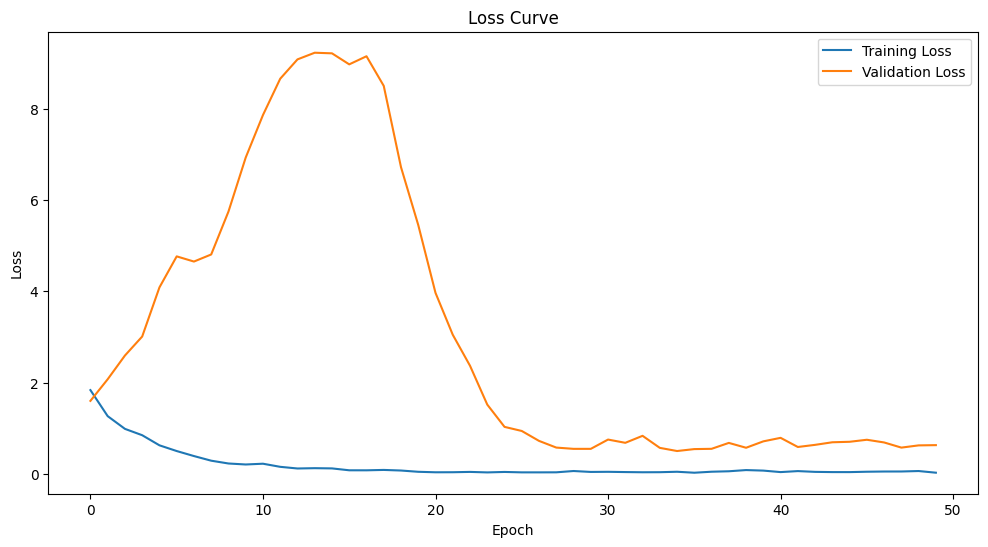

In [54]:
# plot the loss curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


CNN with classification output of one label using time series and current feature

In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate

# One-hot encode labels for multi-class classification
X = data[:, :-1]
num_samples, timesteps = X.shape
num_classes = len(np.unique(labels[:, 0]))

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels[:, 0].ravel())
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

# Split the data into time series and additional numeric feature
X_time_series = data[:, :-1].reshape((num_samples, timesteps, 1))
X_numeric = labels[:, 1].reshape(-1, 1)

# Train-test split
X_train_time_series, X_test_time_series, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(X_time_series, X_numeric, y, test_size=0.2, random_state=42)

# Normalize the time series data
scaler_X = StandardScaler()
X_train_time_series = scaler_X.fit_transform(X_train_time_series.reshape(-1, X_train_time_series.shape[-1])).reshape(X_train_time_series.shape)
X_test_time_series = scaler_X.transform(X_test_time_series.reshape(-1, X_test_time_series.shape[-1])).reshape(X_test_time_series.shape)

# Normalize the numeric feature
scaler_numeric = StandardScaler()
X_train_numeric = scaler_numeric.fit_transform(X_train_numeric)
X_test_numeric = scaler_numeric.transform(X_test_numeric)

# Define the model
input_time_series = Input(shape=(timesteps, 1), name='time_series_input')
input_numeric = Input(shape=(1,), name='numeric_input')

# Time series branch
x = Conv1D(filters=128, kernel_size=3, activation='relu')(input_time_series)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

# Numeric feature branch
y = Dense(64, activation='relu')(input_numeric)
y = BatchNormalization()(y)
y = Dropout(0.2)(y)

# Concatenate branches
combined = Concatenate()([x, y])

# Fully connected layers
combined = Dense(128, activation='relu')(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.2)(combined)
combined = Dense(64, activation='relu')(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.2)(combined)
combined = Dense(64, activation='relu')(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.2)(combined)

# Output layer for multi-class classification
output = Dense(num_classes, activation='softmax')(combined)

# Define the model
model = Model(inputs=[input_time_series, input_numeric], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train_time_series, X_train_numeric], y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate([X_test_time_series, X_test_numeric], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Make predictions
predictions = model.predict([X_test_time_series, X_test_numeric])
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

print(predicted_labels)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 789ms/step - accuracy: 0.3075 - loss: 1.9262 - val_accuracy: 0.3718 - val_loss: 1.5250
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 724ms/step - accuracy: 0.5812 - loss: 1.0988 - val_accuracy: 0.2628 - val_loss: 1.5266
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 715ms/step - accuracy: 0.6879 - loss: 0.7721 - val_accuracy: 0.2308 - val_loss: 1.5661
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 715ms/step - accuracy: 0.7695 - loss: 0.6181 - val_accuracy: 0.2756 - val_loss: 1.4661
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 783ms/step - accuracy: 0.8163 - loss: 0.4979 - val_accuracy: 0.3141 - val_loss: 1.4142
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 793ms/step - accuracy: 0.8912 - loss: 0.3450 - val_accuracy: 0.3269 - val_loss: 1.4242
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 717ms/step - accuracy: 0.9378 - loss: 0.2450 - val_accuracy: 0.4359 - val_loss: 1.5172
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 710ms/step - accuracy: 0.9422 - loss: 0.2185 - val_accu

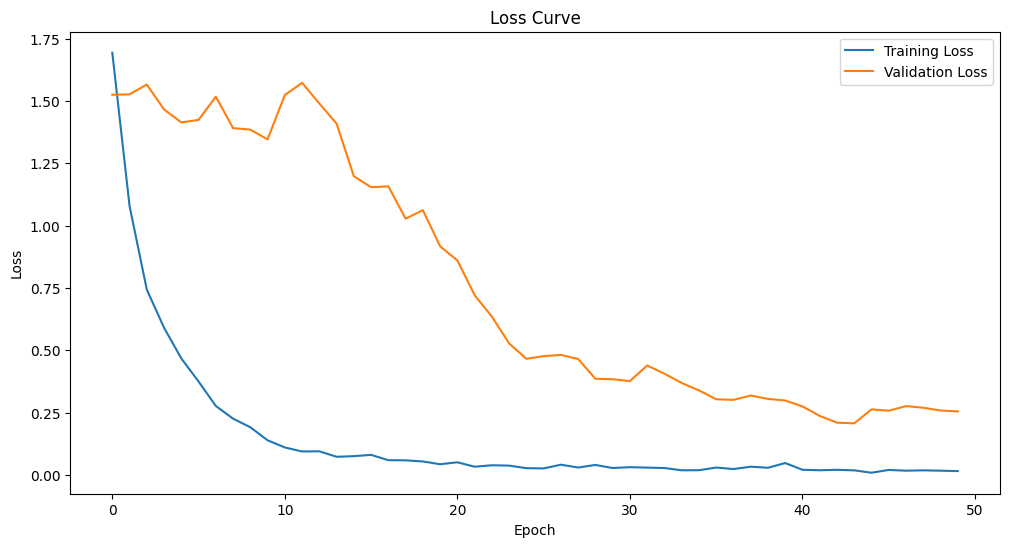

In [56]:
# plot the loss curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


CNN with regression output of pulse width using time series and current output

In [63]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate

X = data[:, :-1]
num_samples, timesteps = X.shape
num_classes = len(np.unique(labels[:, 0]))

data = np.random.randn(num_samples, timesteps + 1)  # Example time series data with one additional feature
labels = np.random.randn(num_samples, 2)  # Example labels for regression

# Split the data into time series and additional numeric feature
X_time_series = data[:, :-1].reshape((num_samples, timesteps, 1))
X_numeric = labels[:, 1].reshape(num_samples, 1)
y = labels[:, 0]  # Use one of the columns in labels for regression target

# Train-test split
X_train_time_series, X_test_time_series, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(X_time_series, X_numeric, y, test_size=0.2, random_state=42)

# Normalize the time series data
scaler_X = StandardScaler()
X_train_time_series = scaler_X.fit_transform(X_train_time_series.reshape(-1, X_train_time_series.shape[-1])).reshape(X_train_time_series.shape)
X_test_time_series = scaler_X.transform(X_test_time_series.reshape(-1, X_test_time_series.shape[-1])).reshape(X_test_time_series.shape)

# Normalize the numeric feature
scaler_numeric = StandardScaler()
X_train_numeric = scaler_numeric.fit_transform(X_train_numeric)
X_test_numeric = scaler_numeric.transform(X_test_numeric)

# Normalize the targets
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Define the model
input_time_series = Input(shape=(timesteps, 1), name='time_series_input')
input_numeric = Input(shape=(1,), name='numeric_input')

# Time series branch
x = Conv1D(filters=128, kernel_size=3, activation='relu')(input_time_series)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

# Numeric feature branch
y = Dense(64, activation='relu')(input_numeric)
y = BatchNormalization()(y)
y = Dropout(0.2)(y)

# Concatenate branches
combined = Concatenate()([x, y])

# Fully connected layers
combined = Dense(128, activation='relu')(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.2)(combined)
combined = Dense(64, activation='relu')(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.2)(combined)
combined = Dense(64, activation='relu')(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.2)(combined)

# Output layer for regression
output = Dense(1)(combined)

# Define the model
model = Model(inputs=[input_time_series, input_numeric], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit([X_train_time_series, X_train_numeric], y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, mae = model.evaluate([X_test_time_series, X_test_numeric], y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

# Make predictions
predictions = model.predict([X_test_time_series, X_test_numeric])
predictions = scaler_y.inverse_transform(predictions)

# print(predictions)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 845ms/step - loss: 3.2380 - mae: 1.4134 - val_loss: 1.1711 - val_mae: 0.8862
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 708ms/step - loss: 2.2370 - mae: 1.1535 - val_loss: 1.1892 - val_mae: 0.8875
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 705ms/step - loss: 1.6550 - mae: 1.0583 - val_loss: 1.5831 - val_mae: 1.0290
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 705ms/step - loss: 1.4854 - mae: 0.9451 - val_loss: 3.4942 - val_mae: 1.5843
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 694ms/step - loss: 1.5005 - mae: 0.9830 - val_loss: 8.6012 - val_mae: 2.7232
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 713ms/step - loss: 1.2553 - mae: 0.8882 - val_loss: 11.0478 - val_mae: 3.1368
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 693ms/step - loss: 1.0288 - mae: 0.8180 - val_loss: 16.3071 - val_mae: 3.8853
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 704ms/step - loss: 1.1111 - mae: 0.8098 - val_loss: 33.9122 - val_mae: 5.7147
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 694

ValueError: Expected 2D array, got 1D array instead:
array=[-1.88610355 -0.82864175  0.97165649  0.49387961  0.67841757 -1.43232277
 -0.97870937 -2.19027987 -0.04767625 -1.01755023 -0.95306121 -1.45747812
  0.35130702  0.49333454  0.3147886   1.06887018 -0.63542107  0.5535893
 -0.25522415 -0.69268699  0.2577365  -0.40625809  0.9087896   1.98580059
 -1.64693841 -0.12708804 -0.45227159 -0.1358982   0.85714858  0.91501686
  0.48226341  0.31347797 -0.80527732  0.36915005  1.30078453  0.10593451
 -1.44956281  1.06582411 -1.02781913 -0.34406268 -1.61211142 -0.46830082
 -1.35649943  0.6167287   0.45519719  0.5310365  -0.55744771  1.37879593
 -0.14225797 -0.57741977 -2.34650392 -1.23099699  0.36666595 -0.35165505
  0.44807317  0.36991996 -0.31257795 -0.3507168  -1.21319351  0.2335909
  1.09932681  0.61099497  0.69658242 -1.63406394  0.86852851 -1.2109117
  0.33500402  0.4907252   0.21425683 -1.23730076 -0.02772962  0.34524439
 -1.71592851  1.13058948  1.00273439 -0.27583655  1.16565612  0.63414124
 -0.80153728  0.25963124 -1.598001    0.78567719 -0.75828182 -1.65365251
 -0.11375403  2.00022672 -0.96597413 -1.00162995 -0.16372631 -0.85227141
  0.76968208  0.55821927  0.7078752   1.67231078 -1.53346537 -0.22309937
  0.49636022  0.53433102 -1.15198633 -0.28801673 -0.1637003  -0.01407799
 -0.17130898  1.16001436  0.50575163 -0.5317156  -0.01048619 -0.11884142
 -1.22440852 -0.79487754 -0.82317538  0.22731085  2.50696147  0.31124046
  1.87504875 -0.74589246  1.62318764 -1.2462816   0.10948479  0.43602414
 -1.0226439   0.62580019 -0.95826823 -1.32071259 -0.41328528 -1.72919204
 -0.7668027   1.65994616 -2.29531161 -0.88989825  0.15695049 -1.18060244
  0.07503549 -0.40380964  0.94357699  2.03165048 -0.93422258 -0.26156451
  1.4410508   1.46360262  0.2847592   0.12073647 -0.9428117  -1.02285476
  0.24453032 -1.36624217 -1.62544919  0.95527683  0.45394593  0.55395844
  0.89903771 -0.99842142  0.89439652  1.1051593  -1.32492159 -0.75264773
  0.58492743 -0.95985344 -0.32596774 -1.26550384 -0.82176125 -1.52097022
  0.46095837  1.07022193 -0.74574085  0.3343563   2.34047723 -0.85245828
  0.90836935  0.79256416  0.17349344  0.90788983  0.8947844  -1.00599694
 -2.0691583  -0.29256055 -0.42428035 -0.25924003  0.43665296  0.7999309
  0.18197561  0.5224351   1.02973229 -2.18000928 -0.58949367 -1.03973514
 -1.41028689  0.79969001 -0.48568011  0.87090337 -1.87145125 -0.38244852
  0.99243825  0.29422885  0.07969847  0.00556157].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

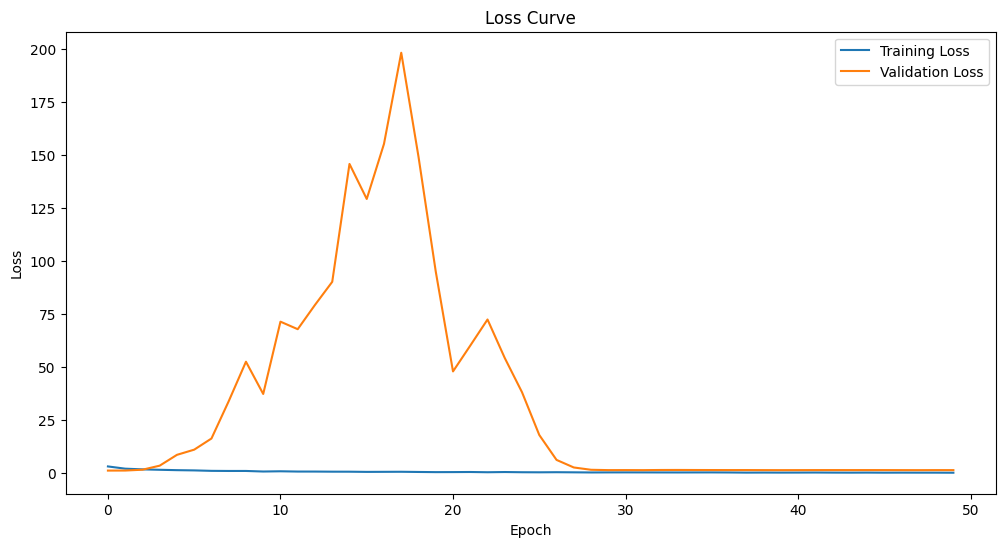

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Print the overall relative accuracy percentage of the regression model
y_test = scaler_y.inverse_transform(y_test)
accuracy = np.mean(1 - np.abs((predictions - y_test) / y_test))
print(f'Overall Relative Accuracy: {accuracy * 100:.2f}%')

# Plot the actual vs predicted values scatter plot as well as the line of perfect predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
